In [1]:
import os
from pathlib import Path
import numpy as np
import time
from scipy.optimize import minimize
from simsopt._core.optimizable import load
from simsopt.geo import ArclengthVariation
from simsopt.geo.surfacerzfourier import SurfaceRZFourier
from simsopt.objectives.fluxobjective import SquaredFlux
from simsopt.objectives.utilities import QuadraticPenalty
from simsopt.geo.curve import curves_to_vtk, create_equally_spaced_curves, create_equally_spaced_windowpane_curves
from simsopt.field.biotsavart import BiotSavart
from simsopt.field.coil import Current, coils_via_symmetries, ScaledCurrent, apply_symmetries_to_curves
from simsopt.geo.curveobjectives import CurveLength, CurveCurveDistance, \
    MeanSquaredCurvature, LpCurveCurvature, CurveSurfaceDistance, LinkingNumber

import matplotlib.pyplot as plt

from simsopt.geo import CurveCWSFourier
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

%matplotlib widget

In [2]:
# Number of unique coil shapes, i.e. the number of coils per half field period:
# (Since the configuration has nfp = 2, multiply by 4 to get the total number of coils.)
ncoils = 5

# Major radius for the initial circular coils:
R0 = 1.0

# Minor radius for the initial circular coils:
R1 = 0.5

# Number of Fourier modes describing each Cartesian component of each coil:
order = 7

WP_WEIGHT_SCALE = 1

# Weight on the curve lengths in the objective function. We use the `Weight`
# class here to later easily adjust the scalar value and rerun the optimization
# without having to rebuild the objective.
LENGTH_WEIGHT = 0.0156434465

# Threshold and weight for the coil-to-coil distance penalty in the objective function:
CC_THRESHOLD = 0.08
CC_WEIGHT = 156.434465

# Threshold and weight for the coil-to-surface distance penalty in the objective function:
CS_THRESHOLD = 0.12
CS_WEIGHT = 1564.34465

# Threshold and weight for the curvature penalty in the objective function:
CURVATURE_THRESHOLD = 12.
CURVATURE_WEIGHT = 0.000000156434465

# Threshold and weight for the mean squared curvature penalty in the objective function:
MSC_THRESHOLD = 11
MSC_WEIGHT = 1.10e-08

# Port size relevant weights
wdd = 1E6
#wco = 0
#wph = 1E3
warc = 1E-1
wufp = 1E-1
wport = 1E-4

# Number of iterations to perform:
MAXITER =  1E4

# File for the desired boundary magnetic surface:
filename = 'input.LandremanPaul2021_QH'

# Directory for output
OUT_DIR = f"./output/"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
# Initialize the boundary magnetic surface:
nphi = 34
ntheta = 32
s = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
fulls = SurfaceRZFourier.from_vmec_input(filename, nphi=nphi, ntheta=ntheta)

# Create the initial coils:
base_tf_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=R0, R1=R1, order=order, numquadpoints=512) 
base_tf_currents = [Current(-1e4) for i in range(ncoils)]

base_curves = base_tf_curves
base_currents = base_tf_currents

coils = coils_via_symmetries(base_curves, base_currents, s.nfp, True)

for c in coils:
    c.unfix_all()


bs = BiotSavart(coils)
bs.set_points(s.gamma().reshape((-1, 3)))
print(bs._coils[0]._current.x)
print(bs._coils[1]._current.x)
print(bs._coils[2]._current.x)
print(bs._coils[3]._current.x)

curves = [c.curve for c in coils]
curves_to_vtk(curves, OUT_DIR + "curves_init")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "surf_init", extra_data=pointData)

[-10000.]
[-10000.]
[-10000.]
[-10000.]


In [4]:
#Define one port
order = 2
qpts = 64
curve_cws = CurveCWSFourier(
    qpts,
    order,
    s
)
nfp = s.nfp
dphi = 1/(2*nfp) * 1/ncoils
phi0 = 3 * dphi

curve_cws.set('phic(0)', phi0)
curve_cws.set('phic(1)', dphi/3.0)
curve_cws.set('thetac(0)', 0.25)
curve_cws.set('thetas(1)', 0.1)

In [5]:
x =np.zeros((10,))
y = np.ones((10,))

In [6]:
np.array([x,y]).transpose().shape

(10, 2)

Text(0, 0.5, 'y')

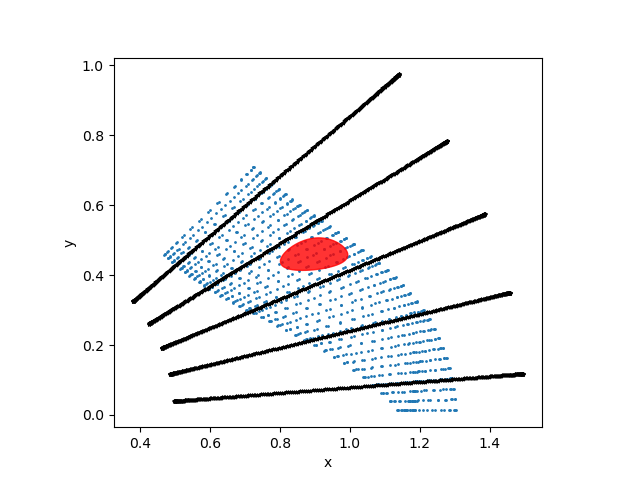

In [7]:
xx = s.gamma().reshape((-1,3))[:,0]
yy = s.gamma().reshape((-1,3))[:,1]

fig, ax = plt.subplots()
ax.scatter(xx,yy,s=1)

g = curve_cws.gamma()
ax.fill(g[:,0], g[:,1], color='r', alpha=0.8)

for c in base_tf_curves:
    g = c.gamma()
    ind = np.where(g[:,2]>0)
    ax.scatter(g[ind,0], g[ind,1], color='k', marker='*', s=5)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [8]:
# Define the individual terms objective function:
Jf = SquaredFlux(s, bs)
Jls = [CurveLength(c) for c in base_curves]
Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=ncoils)
Jcsdist = CurveSurfaceDistance(curves, s, CS_THRESHOLD)
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_curves]
Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
linkNum = LinkingNumber(base_tf_curves)

# Port relavant penalties
Jxyarea = ProjectedEnclosedArea( curve_cws )
Jccxydist = ProjectedCurveCurveDistance( curves, curve_cws, 0.05 )
Jconvex = ProjectedCurveConvexity( curve_cws )
Jarc = ArclengthVariation( curve_cws )
Jufp = DirectedFacingPort(curve_cws)
Jport = -1 * Jxyarea + wdd * Jccxydist + warc * Jarc + wufp * Jufp #+ wco * Jconvex


# Form the total objective function. To do this, we can exploit the
# fact that Optimizable objects with J() and dJ() functions can be
# multiplied by scalars and added:
JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 2.6*ncoils) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist \
    + CURVATURE_WEIGHT * sum(Jcs) \
    + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \
    + QuadraticPenalty(linkNum, 0.1) \
    + wport * Jport

# We don't have a general interface in SIMSOPT for optimisation problems that
# are not in least-squares form, so we write a little wrapper function that we
# pass directly to scipy.optimize.minimize


def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    MaxBdotN = np.max(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    mean_AbsB = np.mean(bs.AbsB())

    
    A = Jxyarea.J()
    CC = Jccxydist.J()
    arc = Jarc.J()
    #convex = Jconvex.J()
    
    outstr = f"J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}, C-S-Sep={Jcsdist.shortest_distance():.2f}"
    outstr += f", ║∇J║={np.linalg.norm(grad):.1e}"
    outstr += f", ⟨B·n⟩/|B|={BdotN/mean_AbsB:.1e}"
    outstr += f", (Max B·n)/|B|={MaxBdotN/mean_AbsB:.1e}"
    outstr += f", Link Number = {linkNum.J()}\n"
    outstr += f"Jport={Jport.J():.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Arc penalty={arc:.2E}"#, Convex={convex:.2E}"
    print(outstr)
    return J, grad

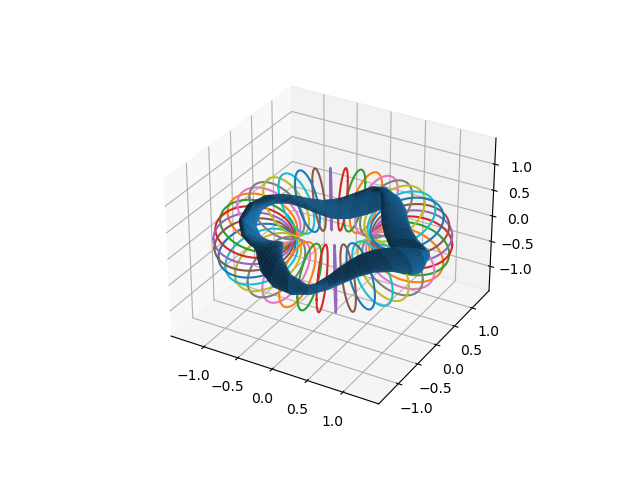

In [9]:
fulls.plot(show=False, close=True)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

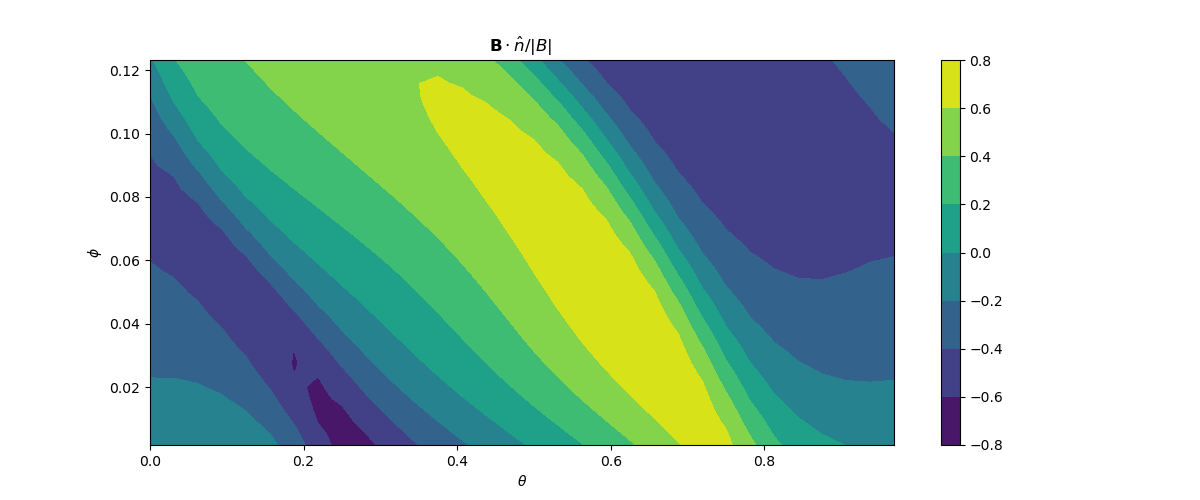

In [10]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

In [11]:
# Jf = SquaredFlux(s, bs)
# Jls = [CurveLength(c) for c in base_curves]
# Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=ncoils)
# Jcsdist = CurveSurfaceDistance(curves, s, CS_THRESHOLD)
# Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_curves]
# Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
# linkNum = LinkingNumber(base_tf_curves)

# # Port relavant penalties
# Jxyarea = ProjectedEnclosedArea( curve_cws )
# Jccxydist = ProjectedCurveCurveDistance( base_tf_curves, curve_cws, 0.05 )
# Jconvex = ProjectedCurveConvexity( curve_cws )
# Jarc = ArclengthVariation( curve_cws )
# Jport = -1 * Jxyarea + wdd * Jccxydist + warc * Jarc + wco * Jconvex
print(np.any(np.isnan(Jf.dJ())))
print(np.any(np.isnan([jj.dJ() for jj in Jls])))
print(np.any(np.isnan(Jccdist.dJ())))
print(np.any(np.isnan(Jcsdist.dJ())))
print(np.any(np.isnan([jj.dJ() for jj in Jcs])))
print(np.any(np.isnan([jj.dJ() for jj in Jmscs])))
print(np.any(np.isnan(linkNum.dJ())))
print(np.any(np.isnan(Jxyarea.dJ())))
print(np.any(np.isnan(Jccxydist.dJ())))
print(np.any(np.isnan(Jconvex.dJ())))
print(np.any(np.isnan(Jarc.dJ())))

False
False
False
False
False
False
False
False
False
False
False



################################################################################
### Perform a Taylor test ######################################################
################################################################################

J=1.2e-01, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=4.2e+01, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 1.8187906185185628e-16
Jport=5.79E+02, Area=1.34E-02, Coil-coil dist=5.79E-04, Arc penalty=1.49E-02
J=1.4e-01, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.5, 2.6, 2.6, 2.5, 2.6], ∫ϰ²/L=[4.1, 4.1, 4.1, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=4.7e+01, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 3.6246206237593206e-15
Jport=7.00E+02, Area=1.40E-02, Coil-coil dist=7.00E-04, Arc penalty=1.85E-02
J=1.2e-01, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7

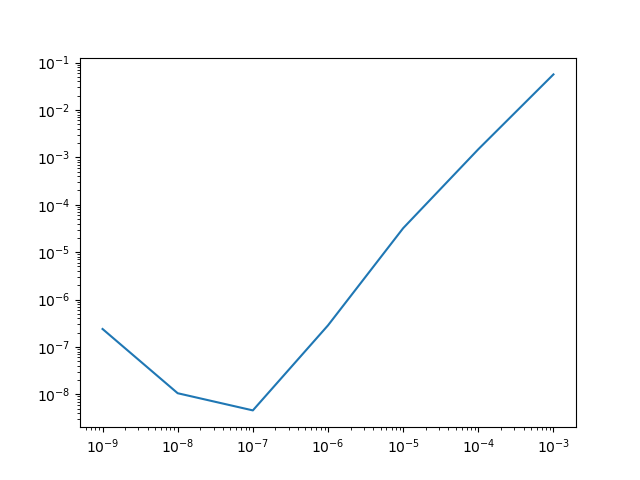

In [12]:
print("""
################################################################################
### Perform a Taylor test ######################################################
################################################################################
""")
f = fun
dofs = JF.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
myerr = []
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh)

plt.figure()
plt.loglog(myeps, np.abs(myerr))

In [13]:
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)

J=1.2e-01, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=4.2e+01, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 1.8187906185185628e-16
Jport=5.79E+02, Area=1.34E-02, Coil-coil dist=5.79E-04, Arc penalty=1.49E-02
J=1.2e+01, Jf=4.6e-03, ⟨B·n⟩=3.3e-02, Len=sum([3.1, 3.1, 4.3, 4.6, 3.1])=18.3, ϰ=[2.0, 2.0, 39.3, 45.1, 2.0], ∫ϰ²/L=[4.1, 4.1, 50.0, 55.4, 4.1], C-C-Sep=0.00, C-S-Sep=0.15, ║∇J║=4.4e+02, ⟨B·n⟩/|B|=4.0e-01, (Max B·n)/|B|=8.9e-01, Link Number = 3.910701035032162
Jport=4.34E+04, Area=-1.35E+00, Coil-coil dist=4.34E-02, Arc penalty=2.65E+02
J=5.0e-01, Jf=4.3e-03, ⟨B·n⟩=3.2e-02, Len=sum([3.1, 3.1, 3.2, 3.2, 3.1])=15.8, ϰ=[2.0, 2.0, 5.3, 6.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 6.5, 7.2, 4.0], C-C-Sep=0.07, C-S-Sep=0.16, ║∇J║=1.0e+02, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 3.4403160442730203e-15
Jport=4.29E+03, Area=-1.55E-01, Coil-coil dist=4.29E-03, Arc

In [14]:
print(res.message)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


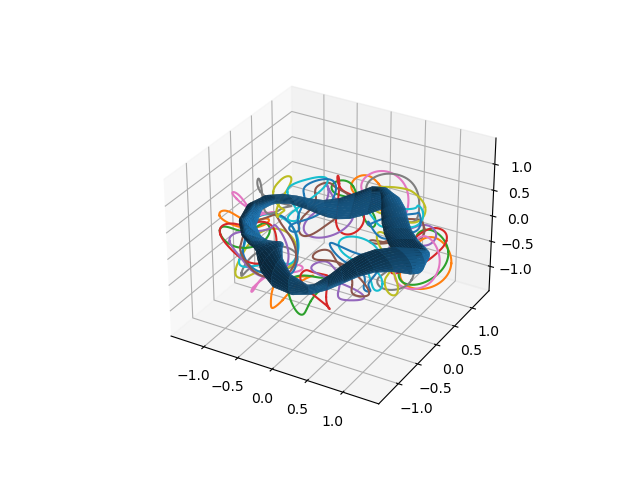

In [15]:
fulls.plot(show=False, close=True)
ax = plt.gca()
for c in bs.coils:
    c.curve.plot(ax=ax, show=False)

Text(0.5, 0, '$\\theta$')

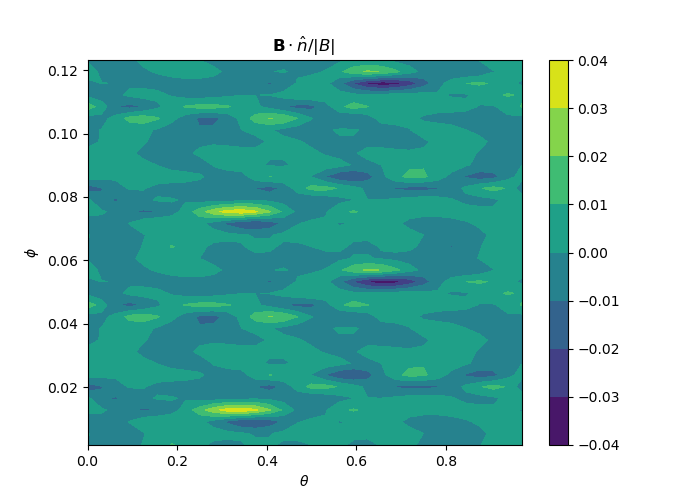

In [22]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(fulls.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * fulls.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

Text(0, 0.5, 'y')

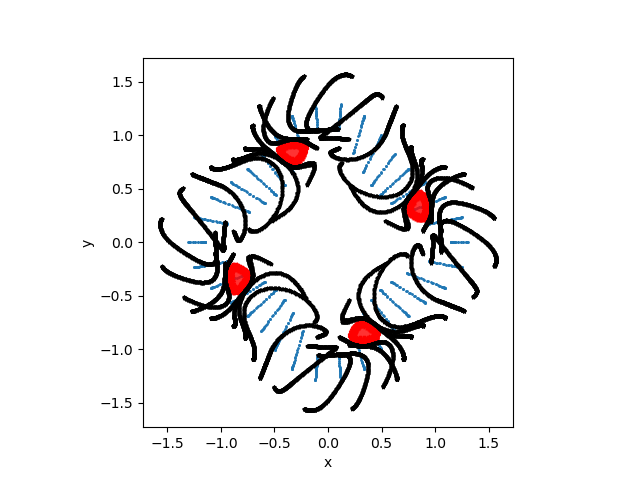

In [17]:
xx = fulls.gamma().reshape((-1,3))[:,0]
yy = fulls.gamma().reshape((-1,3))[:,1]

fig, ax = plt.subplots()
ax.scatter(xx,yy,s=1)

full_ports = apply_symmetries_to_curves( [curve_cws], fulls.nfp, False )
for c in full_ports:
    g = c.gamma()
    ax.fill(g[:,0], g[:,1], color='r', alpha=0.8)
    ax.scatter(g[:,0], g[:,1], color='r', marker='*')

for c in bs.coils:
    g = c.curve.gamma()
    ind = np.where(g[:,2]>0)
    ax.scatter(g[ind,0], g[ind,1], color='k', marker='*', s=5)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [18]:
c = load('output/run_01/port_final.json')
g= c.gamma()
plt.plot(g[:,0], g[:,1])

In [19]:
curves_to_vtk(curves, OUT_DIR + f"curves_wport={wport:.2E}_phi0={phi0:.2f}")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "surf_opt_short", extra_data=pointData)
bs.save(OUT_DIR + f'biotsavart_wport={wport:.2E}_phi0={phi0:.2f}.json');

In [20]:
curve_cws.save('test.json')

'{\n  "@module": "simsopt._core.json",\n  "@class": "SIMSON",\n  "@version": "1.2.1.dev37+g089da514.d20240224",\n  "graph": {\n    "$type": "ref",\n    "value": "CurveCWSFourier1"\n  },\n  "simsopt_objs": {\n    "5389958880": {\n      "@module": "simsopt._core.optimizable",\n      "@class": "DOFs",\n      "@name": "5389958880",\n      "@version": "1.2.1.dev37+g089da514.d20240224",\n      "x": {\n        "@module": "numpy",\n        "@class": "array",\n        "dtype": "float64",\n        "data": [\n          1.0,\n          0.1798197877372061,\n          0.01734951154350431,\n          0.00257716016204933,\n          -0.000163788998368274,\n          -2.425305167830765e-05,\n          -8.577683632032374e-05,\n          -0.0003374047917343044,\n          -0.003641359983759378,\n          -0.02444833020873945,\n          -0.08731762429558673,\n          0.1380390474734288,\n          0.02903189084133577,\n          0.006875247108489111,\n          0.0008150566273801188,\n          -2.843